In [2]:
pip install tensorflow-directml-plugin

  Using cached tensorflow_intel-2.10.0-cp39-cp39-win_amd64.whl (262.6 MB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Su

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\Oliver\\anaconda3\\envs\\SOTA_TF\\Lib\\site-packages\\google\\~-pb\\_message.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [4]:
pip install "tensorflow<2.11"

  Using cached tensorflow-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.0.0
    Uninstalling google-auth-oauthlib-1.0.0:
      Successfully uninstalled google-auth-oauthlib-1.0.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.0
    Uninstalling tensorflow-2.13.0:
      Successfully uninstalled tensorflow-2.13.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lion-tf 0.0.1 requires tensorflow>=2.11, but you have tensorflow 2.10.1 which is incompatible.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.10.0 which is incompatible.
tensorflow-cpu 2.10.0 requires tensorflow-intel==2.10.0; platform_system == "Windows", but you have tensorflow-intel 2.13.0 which is incompatible.


In [ ]:
pip uninstall tensorflow

In [5]:
import tensorflow as tf

NotFoundError: C:\Users\Oliver\anaconda3\envs\SOTA_TF\lib\site-packages\tensorflow-plugins\tfdml_plugin.dll not found

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.optimizers import Optimizer
import PIL
from PIL import Image

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## 1. <a name="C22">InceptionV3 Adam</a>
<a href="#toc">Revenir en haut</a>

In [3]:
# Chemin vers le dossier principal contenant les images de chiens
data_dir = 'Images'

In [4]:
# Taille des images que le modèle attend en entrée
img_size = (299, 299)
num_classes = 120
epochs = 20

In [5]:
# Pré-traitement et data augmentation des images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

In [6]:
# Charger les images depuis le répertoire et appliquer la data augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 16508 images belonging to 120 classes.


In [7]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 4072 images belonging to 120 classes.


In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [11]:
# Ajouter une couche GlobalAveragePooling2D et une couche Dense pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [12]:
# Combiner le modèle pré-entraîné avec nos nouvelles couches
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Geler les couches du modèle pré-entraîné pour empêcher leur mise à jour lors de l'entraînement
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Afficher un résumé du modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

### 2.2 Entrainement du modèle

In [18]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
258/258 [==============================] - 524s 2s/step - loss: 0.7317 - accuracy: 0.7897 - val_loss: 0.6849 - val_accuracy: 0.8016
Epoch 2/20
258/258 [==============================] - 534s 2s/step - loss: 0.6023 - accuracy: 0.8205 - val_loss: 0.6778 - val_accuracy: 0.8065
Epoch 3/20
258/258 [==============================] - 528s 2s/step - loss: 0.5464 - accuracy: 0.8334 - val_loss: 0.6220 - val_accuracy: 0.8210
Epoch 4/20
258/258 [==============================] - 529s 2s/step - loss: 0.5177 - accuracy: 0.8425 - val_loss: 0.7318 - val_accuracy: 0.7905
Epoch 5/20
258/258 [==============================] - 531s 2s/step - loss: 0.4838 - accuracy: 0.8500 - val_loss: 0.6914 - val_accuracy: 0.8094
Epoch 6/20
258/258 [==============================] - 532s 2s/step - loss: 0.4689 - accuracy: 0.8554 - val_loss: 0.6684 - val_accuracy: 0.8072
Epoch 7/20
258/258 [==============================] - 531s 2s/step - loss: 0.4657 - accuracy: 0.8546 - val_loss: 0.7108 - val_accuracy: 0.8033

### 2.3 Evaluation du modèle

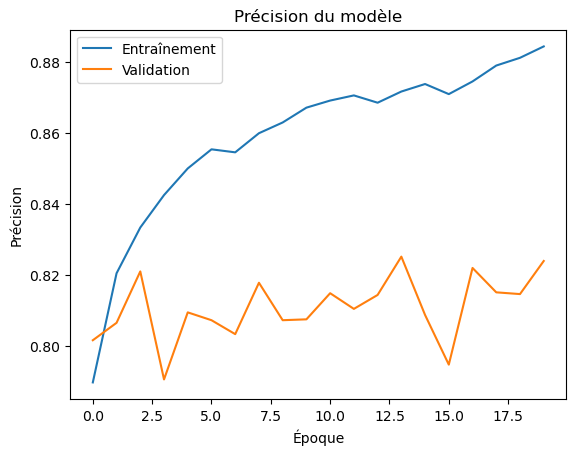

In [19]:
# Tracer les courbes d'apprentissage
# Précision d'entraînement et de validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

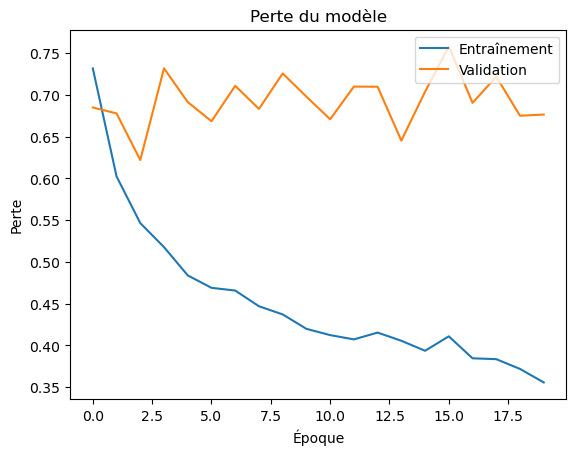

In [20]:
# Perte d'entraînement et de validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

In [21]:
# Classification report pour évaluer les performances du modèle sur le jeu de validation
# Prédictions sur le jeu de validation
Y_val_true = val_generator.classes
Y_val_pred = model.predict(val_generator)

64/64 [==============================] - 99s 2s/step


In [22]:
# Récupérer les indices des classes prédites avec les probabilités les plus élevées
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

In [23]:
# Afficher le classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(Y_val_true, Y_val_pred_classes, target_names=class_labels))

                                precision    recall  f1-score   support

                  Afghan_hound       0.85      0.98      0.91        47
           African_hunting_dog       0.97      0.97      0.97        33
                      Airedale       0.84      0.93      0.88        40
American_Staffordshire_terrier       0.52      0.81      0.63        32
                   Appenzeller       0.56      0.67      0.61        30
            Australian_terrier       0.86      0.82      0.84        39
            Bedlington_terrier       0.97      0.97      0.97        36
          Bernese_mountain_dog       0.80      0.93      0.86        43
              Blenheim_spaniel       0.97      0.86      0.91        37
                 Border_collie       0.64      1.00      0.78        30
                Border_terrier       0.81      1.00      0.89        34
                   Boston_bull       0.94      0.86      0.90        36
          Bouvier_des_Flandres       0.90      0.90      0.90  

## 2. <a name="C22">InceptionV3 Lion</a>
<a href="#toc">Revenir en haut</a>

In [31]:
from lion_tf import Lion

In [32]:
# Chemin vers le dossier principal contenant les images de chiens
data_dir = 'Images'

In [33]:
# Taille des images que le modèle attend en entrée
img_size = (299, 299)
num_classes = 120
epochs = 20

In [34]:
# Pré-traitement et data augmentation des images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

In [35]:
# Charger les images depuis le répertoire et appliquer la data augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 16508 images belonging to 120 classes.


In [36]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 4072 images belonging to 120 classes.


In [37]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [38]:
# Ajouter une couche GlobalAveragePooling2D et une couche Dense pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [39]:
# Combiner le modèle pré-entraîné avec nos nouvelles couches
model = Model(inputs=base_model.input, outputs=predictions)

In [40]:
# Geler les couches du modèle pré-entraîné pour empêcher leur mise à jour lors de l'entraînement
for layer in base_model.layers:
    layer.trainable = False

In [41]:
# taux d'apprentissage constant
lion_optimizer = Lion(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

TypeError: Unexpected keyword argument passed to optimizer: weight_decay. Allowed kwargs are {'clipvalue', 'lr', 'decay', 'global_clipnorm', 'clipnorm'}.

In [14]:
# Compiler le modèle
model.compile(optimizer=lion_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Afficher un résumé du modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

### 2.2 Entrainement du modèle

In [16]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
258/258 [==============================] - 184s 705ms/step - loss: 8.1357e-05 - accuracy: 1.8055e-05 - val_loss: 38.2444 - val_accuracy: 0.0373
Epoch 2/20
 22/258 [=>............................] - ETA: 2:11 - loss: 37.0140 - accuracy: 0.0341

KeyboardInterrupt: 

### 2.3 Evaluation du modèle

In [ ]:
# Tracer les courbes d'apprentissage
# Précision d'entraînement et de validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Perte d'entraînement et de validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Classification report pour évaluer les performances du modèle sur le jeu de validation
# Prédictions sur le jeu de validation
Y_val_true = val_generator.classes
Y_val_pred = model.predict(val_generator)

In [ ]:
# Récupérer les indices des classes prédites avec les probabilités les plus élevées
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

In [ ]:
# Afficher le classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(Y_val_true, Y_val_pred_classes, target_names=class_labels))